In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import  tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
import torchvision
import matplotlib.pyplot as plt
from IPython import display

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
print(torchvision.__version__)

cuda:0
0.17.1+cu121


### Import and Inspect the Dataset

In [3]:
cdata = torchvision.datasets.EMNIST(root='emnist', split='balanced',download=True)


In [4]:
cdata.class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35,
 'a': 36,
 'b': 37,
 'd': 38,
 'e': 39,
 'f': 40,
 'g': 41,
 'h': 42,
 'n': 43,
 'q': 44,
 'r': 45,
 't': 46}

In [5]:
idx = np.where((cdata.targets < 36) & (cdata.targets >= 10))
cdata.targets = cdata.targets[idx];
cdata.data = cdata.data[idx];
print(f"All classes: {cdata.classes}")
print(f"Data size: {cdata.data.shape}")

All classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
Data size: torch.Size([62400, 28, 28])


In [6]:
# Transforming to 4D tensor for conv layers
images = cdata.data.view([62400, 1, 28, 28]).float()
print(f"Tensor shape: {images.shape}")

Tensor shape: torch.Size([62400, 1, 28, 28])


In [7]:
torch.sum(cdata.targets == 0), len(torch.unique(cdata.targets))

(tensor(0), 26)

In [8]:
import copy

letterCategories = cdata.classes
print(letterCategories)
labels = copy.deepcopy(cdata.targets)
print(labels.shape)
print(torch.min(labels), torch.max(labels))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
torch.Size([62400])
tensor(10) tensor(35)


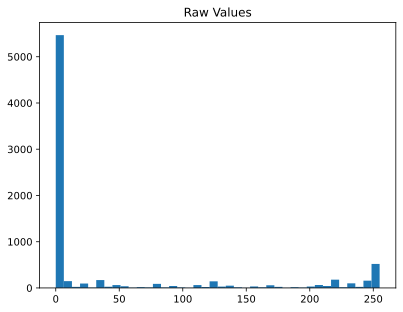

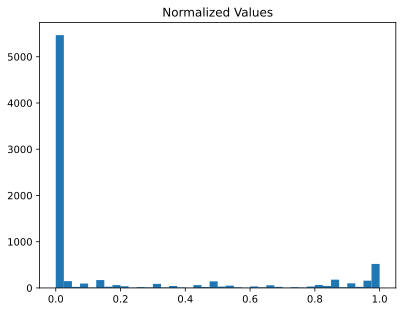

In [9]:
# Before normalizing
plt.hist(images[:10, :, :, :].view(1, -1).detach(), 40)
plt.title("Raw Values")
plt.show()

# Normalize
images /= torch.max(images)

# After normalizing
plt.hist(images[:10, :, :, :].view(1, -1).detach(), 40)
plt.title("Normalized Values")
plt.show()

### Visualize images

In [10]:
labels[100].item()

11

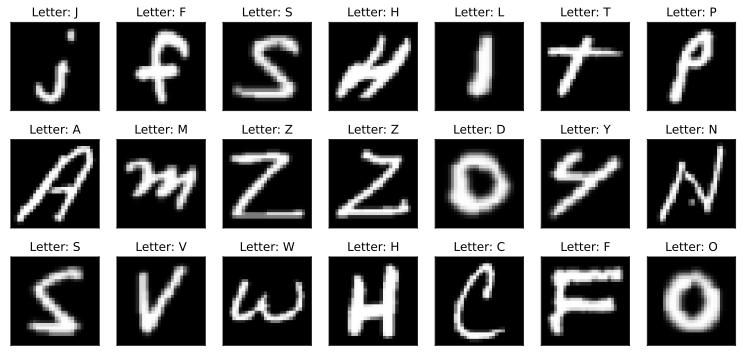

In [11]:
fig, axes = plt.subplots(3, 7, figsize=(13, 6))

for i , ax in enumerate(axes.flatten()):
    which_pic = np.random.randint(images.shape[0])

    image = images[which_pic, 0, :, :].detach()
    letter = letterCategories[labels[which_pic]]

    ax.imshow(image.T, cmap='gray')
    ax.set_title(f"Letter: {letter}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### Train/Test Groups

In [12]:
labels -= 10
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.01)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
print(len(train_data))
batch_size = 128
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=len(test_data))

61776


# DL Model

In [21]:
def make_the_model(print_toggle):
    class EMNISTNet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()
            self.print_toggle = print_toggle

            # Conv1
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, )
            self.bnorm1 = nn.BatchNorm2d(num_features=64)

            # Conv2
            self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
            self.bnorm2 = nn.BatchNorm2d(num_features=128) # Input: number of channels

            # Conv3
            self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
            self.bnorm3 = nn.BatchNorm2d(num_features=256) # Input: number of channels

            self.fc1 = nn.Linear(in_features=2*2*256, out_features=256)
            self.fc2 = nn.Linear(in_features=256, out_features=64)
            self.fc3 = nn.Linear(in_features=64, out_features=26)
            self.res = nn.Softmax()
            
        def forward(self, x):
            if self.print_toggle:
                print(f"Input: {list(x.shape)}")

            # First Block: conv -> max_pool -> bnorm -> relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu((self.bnorm1(x)))
            x = F.dropout(x, p=0.25, training=self.training)
            if self.print_toggle:
                print(f"First Block: {list(x.shape)}")

            # Second Block: conv -> max_pool -> bnorm -> relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu((self.bnorm2(x)))
            x = F.dropout(x, p=0.25, training=self.training)
            if self.print_toggle:
                print(f"Second Block: {list(x.shape)}")

            # Third Block: conv -> max_pool -> bnorm -> relu
            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu((self.bnorm3(x)))
            x = F.dropout(x, p=0.25, training=self.training)
            if self.print_toggle:
                print(f"Third Block: {list(x.shape)}")

            # Reshape for linear layer
            n_units = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(n_units))
            if self.print_toggle:
                print(f"Vectorized: {list(x.shape)}")

            # Linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.fc3(x)
            x = self.res(x)
            if self.print_toggle:
                print(f"Final Output: {list(x.shape)}")
            return x


    model = EMNISTNet(print_toggle)

    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

    return model, loss_fun, optimizer

In [22]:
model, loss_fun, optimizer = make_the_model(True)
print(model)
X, y = next(iter(train_dl))

y_hat = model(X)
print(y_hat.shape)
print(y_hat)
loss = loss_fun(y_hat, torch.squeeze(y))

print(f"Output: {y_hat.shape} | Loss: {loss.item()}")

EMNISTNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=26, bias=True)
  (res): Softmax(dim=None)
)
Input: [128, 1, 28, 28]
First Block: [128, 64, 14, 14]
Second Block: [128, 128, 6, 6]
Third Block: [128, 256, 2, 2]
Vectorized: [128, 1024]
Final Output: [128, 26]
torch.Size([128, 26])
tensor([[0.0327, 0.0374, 0.0352,  ..., 0.0374, 0.0506, 0.0455],
        [0.0333, 0.0423, 0.0437,  ..., 0.0323, 

### Function for training the model

In [24]:
def weights_init(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight.data)
def train_the_model(epochs = 10):
    model, loss_fun, optimizer = make_the_model(False)
    model = model.to(device)
    print(device)
    # init with xavier method
    model.apply(weights_init)
    train_loss = torch.zeros(epochs)
    test_loss = torch.zeros(epochs)
    train_acc = torch.zeros(epochs)
    test_acc = torch.zeros(epochs)

    for epoch_i in tqdm(range(epochs)):
        batch_loss = []
        batch_acc = []

        model.train()
        for X, y in tqdm(train_dl):
            X, y = X.to(device), y.to(device)

            y_hat = model(X)
            loss = loss_fun(y_hat, torch.squeeze(y))
            batch_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()
            batch_acc.append(acc)

        train_acc[epoch_i] = np.mean(batch_acc)
        train_loss[epoch_i] = np.mean(batch_loss)

        model.eval()
        X, y = next(iter(test_dl))
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(X)
            loss = loss_fun(y_hat, torch.squeeze(y))
            acc = torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()

            test_acc[epoch_i] = acc
            test_loss[epoch_i] = loss.item()

    return train_loss, test_loss, train_acc, test_acc, model

### Running the model

In [25]:
train_loss, test_loss, train_acc, test_acc, model = train_the_model(15)

cuda:0


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

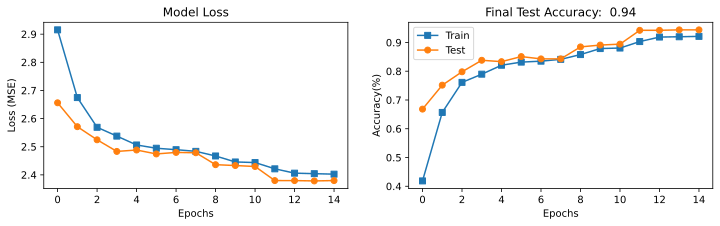

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(train_loss, "s-", label="Train")
ax[0].plot(test_loss, "o-", label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_title("Model Loss")

ax[1].plot(train_acc, "s-", label="Train")
ax[1].plot(test_acc, "o-", label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy(%)")
ax[1].set_title(f"Final Test Accuracy: {test_acc[-1]: 0.2f}")
ax[1].legend()
plt.show()

### Visualize some images

{9, 14, 20, 537, 420, 168, 559, 178, 310, 566, 186, 315, 571, 61, 345, 609, 229, 112, 241, 505, 510}


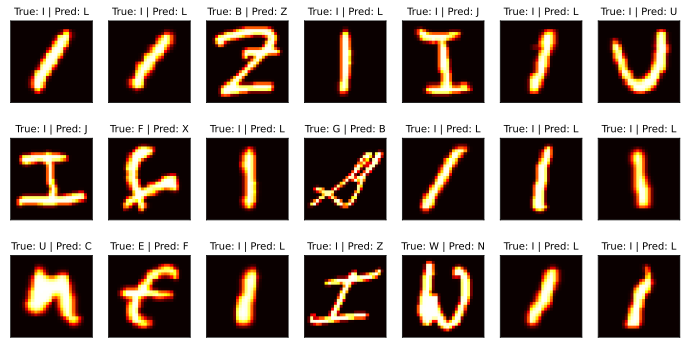

In [35]:
X, y = next(iter(test_dl))

X = X.to(device)
y = y.to(device)

y_hat = model(X)

# rand_idx = np.random.choice(len(y), size=21, replace=False)

fg, axs = plt.subplots(3, 7, figsize=(12, 6))
wa_ids = set()
for i, ax in enumerate(axs.flatten()):
    while 1:
        idx = np.random.choice(len(y))
        if idx in wa_ids:
            continue
        image = np.squeeze(X[idx, 0, :, :]).cpu().T
        true_letter = letterCategories[y[idx] + 10]
        pred_letter = letterCategories[torch.argmax(y_hat, axis=1)[idx] + 10]
        if true_letter != pred_letter:
            wa_ids.add(idx)
            break
    cmap = "hot"
    # cmap = "gray" if true_letter == pred_letter else "hot"
    ax.imshow(image, cmap=cmap)
    ax.set_title(f"True: {true_letter} | Pred: {pred_letter}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
print(wa_ids)
plt.show()

### Accuracy by letter

{'A': 1.0, 'B': 0.9615384615384616, 'C': 0.9565217391304348, 'D': 1.0, 'E': 0.8888888888888888, 'F': 0.9583333333333334, 'G': 0.9523809523809523, 'H': 1.0, 'I': 0.0, 'J': 1.0, 'K': 0.9655172413793104, 'L': 1.0, 'M': 1.0, 'N': 1.0, 'O': 1.0, 'P': 1.0, 'Q': 0.95, 'R': 0.9642857142857143, 'S': 1.0, 'T': 1.0, 'U': 0.9583333333333334, 'V': 0.9545454545454546, 'W': 0.9666666666666667, 'X': 1.0, 'Y': 0.9545454545454546, 'Z': 1.0}


<AxesSubplot: >

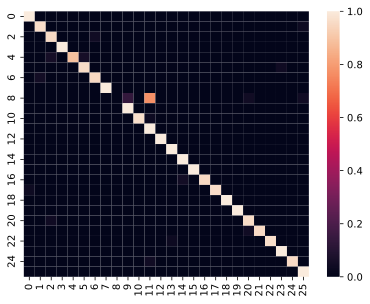

In [45]:
import sklearn.metrics as skm
import seaborn as sns
cm = skm.confusion_matrix(y.cpu(), torch.argmax(y_hat.cpu(), axis=1), normalize='true')
accByLetter = dict()
for i in range(26):
    accByLetter[chr(ord('A') + i)] = cm[i][i]
print(accByLetter)
sns.heatmap(cm)

Save model

In [51]:
torch.save(model.state_dict(), "parameters.pt")
torch.save({
            'epoch': 15,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "checkPoint.pt")